<h1>Getting started with the computational analysis of games:</h1>
<h2>Playing "stripped down" poker</h2>
<i>Theodore L. Turocy</i><br/>
<i>University of East Anglia</i>
<br/><br/>
<h3>EC'16 Workshop
24 July 2016</h3>

In [1]:
import gambit

Gambit version 16.0.0 is the current development version.  You can get it from http://www.gambit-project.org.

In [2]:
gambit.__version__

'16.0.0'

### Inspecting a game

The game that we will use as our starting point is one which many of you may have encountered in some variation.  Myerson's (1991) textbook refers to this as a one-card poker game; Reiley et at (2008) call this "stripped-down poker."

There is a deck consisting of two types of cards: Ace and King.  There are two players, Alice and Bob.  Both start by putting 1 in the pot.  One player (Alice) draws a card; initially assume the cards are in equal proportion in the deck.  Alice sees her card, and then decides whether she wants to raise (add another 1 to the pot) or fold (and concede the pot to Bob).  If she raises, play passes to Bob, who much decide whether to meet her raise (and add another 1 to the pot) or pass (and concede the pot to Alice).  If Alice raises and Bob meets, Alice reveals her card: If it is an Ace, she takes the pot, whereas if it is a King, Bob does.

<center>
<img src="kingbob.jpg" width="30%">
</center>

Here is what the game looks like in extensive form (as drawn by Gambit's graphical viewer, which we will touch on separately):
<center>
<img src="poker.png" width="60%">
</center>

In [3]:
g = gambit.Game.read_game("poker.efg")

Gambit's .efg format is a serialisation of an extensive game.  The format looks somewhat dated (and indeed it was finalised in 1994), but is fast: recently I loaded a game with about 1M nodes in under 2s.

In [4]:
g

EFG 2 R "A simple poker example" { "Alice" "Bob" }
""

c "" 1 "" { "A" 1/2 "K" 1/2 } 0
p "" 1 1 "a" { "R" "F" } 0
p "" 2 1 "b" { "M" "P" } 0
t "" 1 "Alice wins big" { 2, -2 }
t "" 2 "Alice wins" { 1, -1 }
t "" 3 "Bob wins" { -1, 1 }
p "" 1 2 "k" { "R" "F" } 0
p "" 2 1 "b" { "M" "P" } 0
t "" 4 "Bob wins big" { -2, 2 }
t "" 2 "Alice wins" { 1, -1 }
t "" 3 "Bob wins" { -1, 1 }

The game offers a "Pythonic" interface.  Most objects in a game can be accessed via iterable collections.

In [5]:
g.players

[<Player [0] 'Alice' in game 'A simple poker example'>, <Player [1] 'Bob' in game 'A simple poker example'>]

All objects have an optional text label, which can be used to retrieve it from the collection:

In [6]:
g.players["Alice"]

<Player [0] 'Alice' in game 'A simple poker example'>

In this game, Alice has two information sets: when she has drawn the Ace, and when she has drawn the King:

In [7]:
g.players["Alice"].infosets

[<Infoset [0] 'a' for player 'Alice' in game 'A simple poker example'>, <Infoset [1] 'k' for player 'Alice' in game 'A simple poker example'>]

The chance or nature player is a special player in the `players` collection.

In [8]:
g.players.chance

<Player [CHANCE] in game 'A simple poker example'>

In [9]:
g.players.chance.infosets

[<Infoset [0] '' for player '' in game 'A simple poker example'>]

Gambit does sorting of the objects in each collection, so indexing collections by integer indices also works reliably if you save and load a game again.

In [10]:
g.players.chance.infosets[0].actions

[<Action [0] 'A' at infoset '' for player '' in game 'A simple poker example'>, <Action [1] 'K' at infoset '' for player '' in game 'A simple poker example'>]

We can assign particular game objects to variables for convenient referencing.  In this case, we will explore the strategic effects of changing the relative probabilities of the Ace and King cards.

In [11]:
deal = g.players.chance.infosets[0]

In the original version of the game, it was assumed that the Ace and King cards were equally likely to be dealt.

In [12]:
deal.actions["A"].prob

Fraction(1, 2)

In [13]:
deal.actions["K"].prob

Fraction(1, 2)

### Computing Nash equilibria

Gambit offers a variety of methods for computing Nash equilibria of games, which we will discuss in more detail separately.  This is a two-player game in extensive form, for which we can use Lemke's algorithm applied to the *sequence form* of the game.

In the Python interface, solution methods are offered in the `gambit.nash` module.  Each method also is wrapped as a standalone command-line binary.

In [14]:
result = gambit.nash.lcp_solve(g)

The result of this method is a list of (mixed) *behaviour profiles*.  (Future: the return value will be encapsulated in a results class retaining more detailed metadata about the run of the algorithm.)

In this game, there is a unique (Bayes-)Nash equilibrium.

In [15]:
len(result)

1

A behaviour profile looks like a nested list.  Entries are of the form `profile[player][infoset][action]`.

In [16]:
result[0]

[[[Fraction(1, 1), Fraction(0, 1)], [Fraction(1, 3), Fraction(2, 3)]], [[Fraction(2, 3), Fraction(1, 3)]]]

In [17]:
result[0][g.players["Alice"]]

[[Fraction(1, 1), Fraction(0, 1)], [Fraction(1, 3), Fraction(2, 3)]]

In [18]:
result[0][g.players["Bob"]]

[[Fraction(2, 3), Fraction(1, 3)]]

We can compute various interesting quantities about behaviour profiles.  Most interesting is perhaps the payoff to each player; because this is a constant-sum game, this is the value of the game.

In [19]:
result[0].payoff(g.players["Alice"])

Fraction(1, 3)

In [20]:
result[0].payoff(g.players["Bob"])

Fraction(-1, 3)

Bob is randomising at his information set, so he must be indifferent between his actions there.  We can check this.

In [21]:
result[0].payoff(g.players["Bob"].infosets[0].actions[0])

Fraction(-1, 1)

In [22]:
result[0].payoff(g.players["Bob"].infosets[0].actions[1])

Fraction(-1, 1)

As we teach our students, the key to understanding this game is that Alice plays so as to manipulate Bob's beliefs about the likelihood she has the Ace.  We can examine Bob's beliefs over the nodes (members) of his one information set.

Given the structure of the betting rules, Bob becomes indifferent to his actions when he thinks there is a 3/4 chance Alice has the Ace.

In [23]:
result[0].belief(g.players["Bob"].infosets[0].members[0])

Fraction(3, 4)

In [24]:
result[0].belief(g.players["Bob"].infosets[0].members[1])

Fraction(1, 4)

### Construction of the reduced normal form

The call to `lcp_solve` above uses the sequence form rather than the (reduced) strategic form of the game.  This representation takes advantage of the tree structure, and can avoid (in many games of interest) the exponential blowup of the size of the strategic form relative to the extensive form.  (More details on this in a while!)

Nevertheless, the reduced strategic form of a game can be of interest.  Gambit implements transparently the conversions between the extensive and strategic representations.  For games in extensive form, the reduced strategic form is computed on-the-fly from the game tree; that is, the full normal form payoff tables are not stored in memory.

Each player has a data member `strategies` which lists the reduced normal form strategies (s)he has.

In [25]:
g.players["Alice"].strategies

[<Strategy [0] '11' for player 'Alice' in game 'A simple poker example'>, <Strategy [1] '12' for player 'Alice' in game 'A simple poker example'>, <Strategy [2] '21' for player 'Alice' in game 'A simple poker example'>, <Strategy [3] '22' for player 'Alice' in game 'A simple poker example'>]

In [26]:
g.players["Bob"].strategies

[<Strategy [0] '1' for player 'Bob' in game 'A simple poker example'>, <Strategy [1] '2' for player 'Bob' in game 'A simple poker example'>]

We can also do a quick visualisation of the payoff matrix of the game using the built-in HTML output (plus Jupyter's inline rendering of HTML!)

**Disclaimer**: There's a bug in the 16.0.0 release which prevents the correct generation of HTML; this will be corrected in 16.0.1 (and is corrected in the 'master' branch of the git repository already).

In [27]:
import IPython.display; IPython.display.HTML(g.write('html'))

,1,2
11,"0,0","1,-1"
12,"1/2,-1/2","0,0"
21,"-3/2,3/2","0,0"
22,"-1,1","-1,1"


**Bonus note**: Gambit also supports writing out games using Martin Osborne's sgame LaTeX style: https://www.economics.utoronto.ca/osborne/latex/.  This doesn't have auto-rendering magic in Jupyter, but it's all ready to cut-and-paste to your favourite editor.

In [28]:
print g.write('sgame')

\begin{game}{4}{2}[Alice][Bob]
&1 & 2\\
11 &  $0,0$  &  $1,-1$ \\
12 &  $1/2,-1/2$  &  $0,0$ \\
21 &  $-3/2,3/2$  &  $0,0$ \\
22 &  $-1,1$  &  $-1,1$ 
\end{game}



We can convert our behaviour profile to a corresponding mixed strategy profile.  This is indexable as a nested list with elements `[player][strategy]`.

In [29]:
msp = result[0].as_strategy()
msp

[[Fraction(1, 3), Fraction(2, 3), Fraction(0, 1), Fraction(0, 1)], [Fraction(2, 3), Fraction(1, 3)]]

Of course, Alice will receive the same expected payoff from this mixed strategy profile as she would in the original behaviour profile.

In [30]:
msp.payoff(g.players["Alice"])

Fraction(1, 3)

We can also ask what the expected payoffs to each of the strategies are.  Alice's last two strategies correspond to folding when she has the Ace, which is dominated.

In [31]:
msp.strategy_values(g.players["Alice"])

[Fraction(1, 3), Fraction(1, 3), Fraction(-1, 1), Fraction(-1, 1)]

### Automating/scripting analysis

The real gain in having libraries for doing computation in game theory is to be able to script computations.  For example, we can explore how the solution to the game changes, as we change the probability that Alice is dealt the Ace.

Payoffs and probabilities are represented in games in Gambit as exact-precision numbers, which can be either rational numbers of (exact-precision) decimals.  These are called `gambit.Rational` and `gambit.Decimal`, and are compatible with the Python `fractions.Fraction` and `decimal.Decimal` classes, respectively.  (In Gambit 16.0.0, they are derived from them.)

**Caveat/Tip**: This means one cannot set a payoff or probability to be a floating-point number.  We justify this based on the principle "explicit is better than implicit."  In two-player games, the extreme points of the set of Nash equilibria are rational numbers, whenever the data of the game are rational, and the Gambit equilibrium computation methods take advantage of this.  If the payoff of a game were specified as a floating-point number, e.g. 0.333333 instead of 1/3, surprising results can occur due to rounding. 

In [32]:
import pandas
probs = [ gambit.Rational(i, 20) for i in xrange(1, 20) ]
results = [ ]
for prob in probs:
    g.players.chance.infosets[0].actions[0].prob = prob
    g.players.chance.infosets[0].actions[1].prob = 1-prob
    result = gambit.nash.lcp_solve(g)[0]
    results.append({ "prob": prob,
                     "alice_payoff": result.payoff(g.players["Alice"]),
                     "bluff": result[g.players["Alice"].infosets[1].actions[0]],
                     "belief": result.belief(g.players["Bob"].infosets[0].members[1]) })
df = pandas.DataFrame(results)
df

,alice_payoff,belief,bluff,prob
0,-13/15,1/4,1/57,1/20
1,-11/15,1/4,1/27,1/10
2,-3/5,1/4,1/17,3/20
3,-7/15,1/4,1/12,1/5
4,-1/3,1/4,1/9,1/4
5,-1/5,1/4,1/7,3/10
6,-1/15,1/4,7/39,7/20
7,1/15,1/4,2/9,2/5
8,1/5,1/4,3/11,9/20
9,1/3,1/4,1/3,1/2


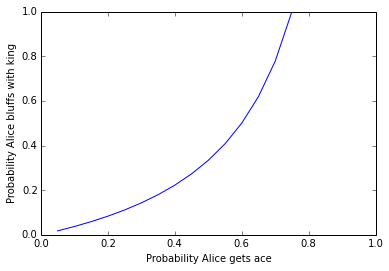

In [33]:
import pylab
%matplotlib inline
pylab.plot(df.prob, df.bluff, '-')
pylab.xlabel("Probability Alice gets ace")
pylab.ylabel("Probability Alice bluffs with king")
pylab.show()

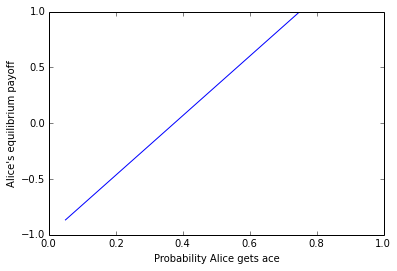

In [34]:
pylab.plot(df.prob, df.alice_payoff, '-')
pylab.xlabel("Probability Alice gets ace")
pylab.ylabel("Alice's equilibrium payoff")
pylab.show()

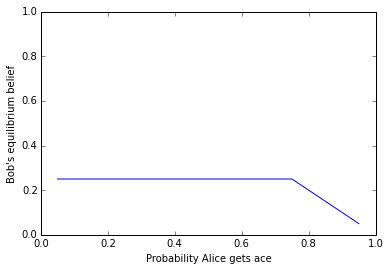

In [35]:
pylab.plot(df.prob, df.belief, '-')
pylab.xlabel("Probability Alice gets ace")
pylab.ylabel("Bob's equilibrium belief")
pylab.ylim(0,1)
pylab.show()

As a final experiment, we can also change the payoff structure instead of the probability of the high card.  How would the equilibrium change if a Raise/Meet required putting 2 into the pot instead of 1?

In [36]:
deal.actions[0].prob = gambit.Rational(1,2)

In [37]:
deal.actions[1].prob = gambit.Rational(1,2)

The `outcomes` member of the game lists all of the outcomes.  An outcome can appear at multiple nodes.  Outcomes, like all other objects, can be given text labels for easy reference.

In [38]:
g.outcomes["Alice wins big"]

<Outcome [0] 'Alice wins big' in game 'A simple poker example'>

In [39]:
g.outcomes["Alice wins big"][0] = 3

In [40]:
g.outcomes["Alice wins big"][1] = -3

In [41]:
g.outcomes["Bob wins big"][0] = -3

In [42]:
g.outcomes["Bob wins big"][1] = 3

Once again, solve the revised game using Lemke's algorithm on the sequence form.

In [43]:
result = gambit.nash.lcp_solve(g)

In [44]:
len(result)

1

In [45]:
result[0]

[[[Fraction(1, 1), Fraction(0, 1)], [Fraction(1, 2), Fraction(1, 2)]], [[Fraction(1, 2), Fraction(1, 2)]]]

The value of the game to Alice is now higher: 1/2 instead of 1/3 with the original payoffs.

In [46]:
result[0].payoff(g.players["Alice"])

Fraction(1, 2)

Bob's equilibrium belief about Alice's hand is also different of course, as he now is indifferent between meeting and passing Alice's raise when he thinks the chance she has the Ace is 2/3 (instead of 3/4 before).

In [47]:
result[0].belief(g.players["Bob"].infosets[0].members[0])

Fraction(2, 3)

### Serialising the game in other formats

We already saw above some of the formats that can be used to serialise games.  There are a few other standard options.  For example, Gambit also has a format for games in strategic (or normal) form.  You can get the reduced normal form of the extensive game in this format directly:

In [48]:
print g.write('nfg')

NFG 1 R "A simple poker example" { "Alice" "Bob" }

{ { "11" "12" "21" "22" }
{ "1" "2" }
}
""

0 0 
1 -1 
-2 2 
-1 1 
1 -1 
0 0 
0 0 
-1 1 




Also, we can write the game out in the XML format used by Game Theory Explorer:

In [49]:
print g.write('gte')

<gte version="0.1">
  <gameDescription/>
  <display>
    <color player="1">#FF0000</color>
    <color player="2">#0000FF</color>
    <font>Times</font>
    <strokeWidth>1</strokeWidth>
    <nodeDiameter>7</nodeDiameter>
    <isetDiameter>25</isetDiameter>
    <levelDistance>75</levelDistance>
  </display>
  <players>
    <player playerId="1">Alice</player>
    <player playerId="2">Bob</player>
  </players>
  <extensiveForm>
    <node>
      <node player="Alice" prob="1/2" move="A">
        <node iset="b" player="Bob" move="R">
          <outcome move="M">
            <payoff player="Alice">3</payoff>
            <payoff player="Bob">-3</payoff>
          </outcome>
          <outcome move="P">
            <payoff player="Alice">1</payoff>
            <payoff player="Bob">-1</payoff>
          </outcome>
        </node>
        <outcome move="F">
          <payoff player="Alice">-1</payoff>
          <payoff player="Bob">1</payoff>
        </outcome>
      </node>
      <node player="Al